# ASSIGNMENT 3: NETWORK SIMULATION

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import copy

# Part 0: The basic model

The basic model is provided by: https://gist.github.com/cscheffler/f8f8416513356e184e9568fa69c90889

In [2]:
class BasicSocialDynamics():
    def __init__(self, size = 50, alpha = 0.03, beta = 0.3, gamma = 4, prob_new_edge = 0.01):
        """
        Size is the number of nodes in the network
        alpha is the rate at which a node adjust its opinion to get closer
            to its neighbor. 
            
        beta is the rate at which the weight of an edge changes in response
            to the opinion change. 
            
        gamma is the pickiness of a node. If the node difference is greater
            than 1/gamma, the edge weight will decrease. 
        """
        self.size = size
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.prob_new_edge = prob_new_edge
        
        #initialize the network configuration:
        self.config = nx.watts_strogatz_graph(size, 5, 0.5)
        
        #the initial weight of all edges is 0.5
        for edge in self.config.edges:
            self.config.edges[edge]['weight'] = 0.5
        #randomize the opinions in nodes between 0 and 1:
        for node in self.config.nodes:
            self.config.nodes[node]['opinion'] = random.randint(0, 1)
        self.layout = nx.spring_layout(self.config)
        self.step = 0
        self.converge = False
        self.split = False
        
    def display(self):
        """
        Draw the network
        """
        self.layout = nx.spring_layout(self.config, pos = self.layout, iterations = 5)
        
        nx.draw(
            self.config, pos = self.layout, with_labels = True,
            node_color = [self.config.nodes[i]['opinion'] for i in self.config.nodes],
            edge_color = [self.config.edges[edge]['weight'] for edge in self.config.edges],
            edge_cmap = plt.cm.binary, edge_vmin = 0, edge_vmax = 1,
            alpha = 0.7, vmin = 0, vmax = 1)
        plt.title("Step: " + str(self.step))
        
    def degrees_display(self):
        """
        Show the degree histogram for the network
        """
        degrees = [self.config.degree(node) for node in self.config.nodes]
        plt.figure()
        plt.hist(degrees)
        plt.xlabel("Degree")
        plt.title("Step: " + str(self.step))
    
    def check_converge(self):
        """
        Check if the network is converged or not.
        The result will show in self.converge attribute.
        A network is converged if the largest opinion difference in the network is less than 0.1
        """
        opinions = [self.config.nodes[node]['opinion'] for node in self.config.nodes]
        if max(opinions) - min(opinions) < 0.1:
            self.converge = True
        else:
            self.converge = False
            
    def check_split(self):
        """
        Check if the network is splitted into two clusters or not.
        The result will show in self.split attribute. 
        A network is split if the number of extreme edges - the edges that connect two extreme ideas,
        is less than 1% of the total number of edges.
        """
        
        extreme_edges = [] #The edges that connect two extremes ideas (opinion difference >= 0.5)
        for edge in self.config.edges:
            if abs(self.config.nodes[edge[0]]['opinion'] - self.config.nodes[edge[1]]['opinion']) >= 0.5:
                extreme_edges.append(edge)
        if len(extreme_edges)/len(self.config.edges) < 0.01:
            self.split = True
        else:
            self.split = False
                
    def update(self):
        if random.uniform(0, 1) < self.prob_new_edge:
            #Create a new edge with weight 0.5 between two unconnected nodes:
            nodes = list(self.config.nodes)
            while True:
                new_edge = np.random.choice(nodes, 2)
                if new_edge not in self.config.edges:
                    break
            self.config.add_edge(new_edge[0], new_edge[1], weight = 0.5)
            
        else:
            #select a random edge and update node opinions and edge weight:
            edge = random.choice(list(self.config.edges))
            weight = self.config.edges[edge]['weight']
            opinions = [self.config.nodes[node]['opinion'] for node in edge]
            
            for i in [0, 1]:
                #update the opinion of each node in the random edge
                self.config.nodes[edge[i]]['opinion'] = (
                    opinions[i] + self.alpha*weight*(opinions[1-i] - opinions[i]))
            #update the weight between two nodes after the opinion change
            self.config.edges[edge]['weight'] = (
                weight + self.beta*weight*(1-weight)*(1-self.gamma*abs(opinions[0] - opinions[1])))
                
            #remove weak connections:
            if self.config.edges[edge]['weight'] < 0.05:
                self.config.remove_edge(*edge)
        self.step += 1

# Part 1: Propose 2-3 modifications

- Modification 1: Charisma
Each node will be assigned with a charisma value (c) of either 1 or 2. The nodes of c = 2 are charismatic. If a node interacts with a charismatic node, the opinion adjustment will be higher than the value from the basic model. This impact is shown in the equation: 
$$o_i' - o_i = c_j\alpha w_{ij} (o_j - o_i)$$
(where j is a charismatic node)

The charisma also impacts the weight of the associated edge. If the opinion difference results in the weight decrease ($1-\gamma |o_j - o_i| < 0$, the charisma slows down that the weight decreases: 
$$w_{ij}' - w_{ij} = \frac{1}{max(c_i,c_j)} \beta w_{ij} (1- w_{ij}) (1-\gamma |o_j - o_i|)$$

If the opinion difference results in the weight increase ($1-\gamma |o_j - o_i| > 0$, the charisma accelerates that the weight increase: 
$$w_{ij}' - w_{ij} = max(c_i,c_j) \beta w_{ij} (1- w_{ij}) (1-\gamma |o_j - o_i|)$$

- Modification 2: Opinion difference affects the new node connection

New connection can only made between two similar ideas. Beside the probability condition, new node connection also requires that the opinion difference between two nodes must be smaller than 0.5. 

# Part 2: Local Analysis:

*Analyze how the proposed changes affect the relationship between 2 people:*

- Modification 1 increases the likelihood of convergence, because the opinion adjustment accelerated by the charisma.
- Modification 2 results in selective connection. Selective connection can strengthen those connections. This modification doesn't affect the existing relationships. However, in the large scale, this modification does not allow making connection between two extreme opinions. So, this modification reduces the time required for the whole network to split.

*Analyze mathematically to choose the values of parameters for which we can observe opinions to converge or diverge and the relationship strengths to increase or decrease:*

The equations from the basic model:
$$o_i' - o_i = \alpha w_{ij} (o_j - o_i)$$
$$w_{ij}' - w_{ij} = \beta w_{ij} (1- w_{ij}) (1-\gamma |o_j - o_i|)$$

$\alpha$ is the diffusion constant. Lower $\alpha$ means that the opinion adjustment is low, compared to the weight decreases. So, a low $\alpha$ causes a split. This inference can be interpreted as opinion change is too low and people hate each other before they can reach a consensus. Higher $\alpha$ increases the opinion adjustment, thus, leads to rapid opinion convergence. This inference means that people quickly change their opinion, reach a consensus.

$\beta$ determines the rate of weight change. A low $\beta$ means that the rate of weight change is low, so the relationship's strength is less affected by the opinion difference. So, it's easier to converge two opinions as their relationship still maintains. If $\beta$ is high, the relationship change will be faster. High relationship change can accelerate the relationship split if the opinion difference is associated with relationship weaken (determined by $\gamma$ session below).   

$\gamma$ determines whether the opinion difference results a stronger or a weaker relationship. If $(1-\gamma |o_j - o_i|) > 0$, the relationship becomes stronger as $w_{ij}' - w_{ij} > 0$. If $(1-\gamma |o_j - o_i|) < 0$, the relationship becomes weaker as $w_{ij}' - w_{ij} < 0$

In [3]:
class LocalAnalysis():
    def __init__(self, alpha = 0.03, beta = 0.3, gamma = 4, difference = 1, weight = 0.5):
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        
        #initialize the network of 2 nodes and 1 edge:
        self.config = nx.erdos_renyi_graph(2,1)
        
        for edge in self.config.edges:
            self.config.edges[edge]['weight'] = weight
        #Assign the opinions so that the opinion difference is "difference" initiated
        self.config.nodes[0]['opinion'] = difference
        self.config.nodes[1]['opinion'] = 0
            
        #Assign the charisma for each node. As the probability of having charisma is 50/50 (used in simulation),
        #in the local analysis, one node will have charisma of 1, and the other node will have charisma of 2. 
        self.config.nodes[0]['charisma'] = 2 #High impact on opinion difference and weight
        self.config.nodes[1]['charisma'] = 1 #No impact on opinion difference and weight
                 
    def update(self):
        edge = (0,1)
        weight = self.config.edges[edge]['weight']
        opinions = [self.config.nodes[node]['opinion'] for node in edge]
        charismas = [self.config.nodes[node]['charisma'] for node in edge]

        for i in [0, 1]:
            #update the opinion of each node in the random edge.
            #the opinion change for one node (i) is dependent on the charistma of the other node (1-i)
            self.config.nodes[edge[i]]['opinion'] = (
                opinions[i] + charismas[1-i]*self.alpha*weight*(opinions[1-i] - opinions[i]))

        #update the weight between two nodes:
        if 1-self.gamma*abs(opinions[0] - opinions[1]) > 0:
            #If the relationship is supposed to be stronger, the charisma accelerates that increase:
            #this impact is shown in the coefficient 2
            self.config.edges[edge]['weight'] = (
                weight + 2*self.beta*weight*(1-weight)*(1-self.gamma*abs(opinions[0] - opinions[1])))
        else: 
            #if the relationship is supposed to be weaker, the charisma slows down that decrease:
            #this impact is shown in the coefficient 1/2
            self.config.edges[edge]['weight'] = (
                weight + 1/2*self.beta*weight*(1-weight)*(1-self.gamma*abs(opinions[0] - opinions[1])))
        
        #remove weak connections:
        if self.config.edges[edge]['weight'] < 0.05:
            self.config.edges[edge]['weight'] = 0

In [4]:
def monitor_variable(sim, init_diff, init_weight):
    """
    Run simulation of the network (of two nodes) to trace the opinion differece and weight.
    """
    result = [[init_diff, init_weight]] 
    for _ in range(300):
        sim.update()
        #Monitor the opinion difference and the weight:
        new_diff = abs(sim.config.nodes[0]['opinion'] - sim.config.nodes[1]['opinion'])
        new_weight = sim.config.edges[(0,1)]['weight']
        
        result.append([new_diff, new_weight])
    return result

In [5]:
#draw arrow:
def draw_vector_field(alpha, beta, gamma):
    """
    Return the gradient of opinion difference and weight at each point in the plot
    """
    for x in np.linspace(0,1,10):
        for y in np.linspace(0,1,10):
            dx = -3*alpha*y*x
            dy = 2*beta*y*(1-y)*(1-gamma*x) if 1-gamma*x > 0 else  1/2*beta*y*(1-y)*(1-gamma*x)
            plt.arrow(x,y, dx, dy, head_width=0.01, alpha = 0.9)

In [6]:
#Create a grid of the starting points for monitoring lines in the plot
grid = []
for weight in np.linspace(0, 1, 20):
    grid.append([1, weight])
for diff in np.linspace(0.25, 1, 30):
    grid.append([diff,0.95])
for diff in np.linspace(0, 0.25, 10):
    grid.append([diff, 0.05])

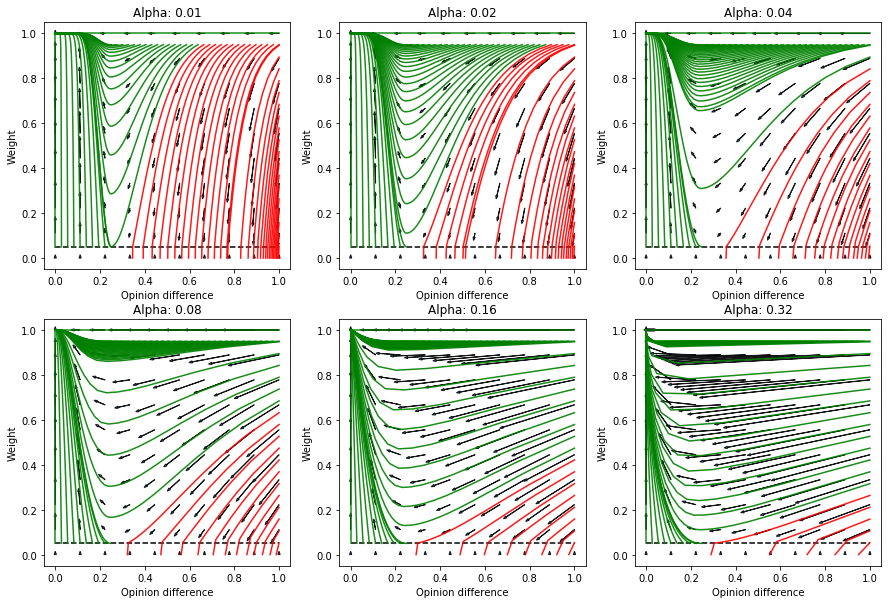

In [7]:
alpha_array = [0.01, 0.02, 0.04, 0.08, 0.16, 0.32]
beta = 0.3
gamma = 4
ncolumns = 3
nrows = len(alpha_array)//ncolumns
fig, axes = plt.subplots(nrows, ncolumns, figsize=(ncolumns*5, nrows*5), sharex=True, sharey=True)
plt_index = 0

for alpha in alpha_array:
    plt_index += 1
    plt.subplot(nrows, ncolumns, plt_index)
    draw_vector_field(alpha, beta, gamma)
    plt.plot([0, 1], [0.05, 0.05], '--', color = "black") #line to set the lower bound of weight.
    plt.title('Alpha: %.2f' %alpha)
    plt.xlabel('Opinion difference')
    plt.ylabel('Weight')
    
    for diff, weight in grid:
        sim = LocalAnalysis(alpha = alpha, difference = diff, weight = weight)
        result = monitor_variable(sim, diff, weight)
        plt.plot([result[time][0] for time in range(len(result))], 
            [result[time][1] for time in range(len(result))], 
            color = ("Red" if result[-1][1] == 0 else "Green"), alpha=0.9)

*Figure 1: The vector field plot at different values of alpha. Green lines represent converged cases, while red lines represent opinion split*

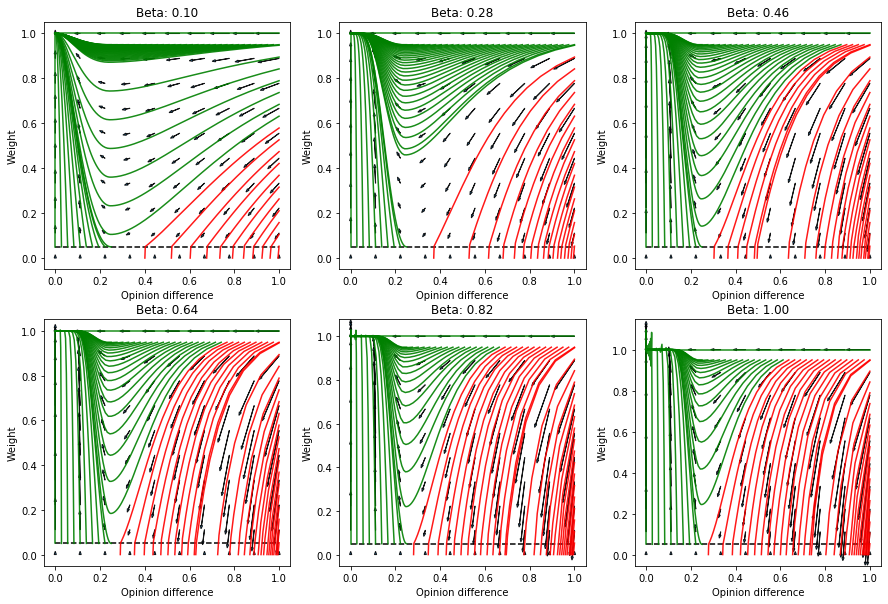

In [8]:
alpha = 0.03
beta_array = np.linspace(0.1, 1, 6)
gamma = 4
ncolumns = 3
nrows = len(beta_array)//ncolumns
fig, axes = plt.subplots(nrows, ncolumns, figsize=(ncolumns*5, nrows*5), sharex=True, sharey=True)
plt_index = 0

for beta in beta_array:
    plt_index += 1
    plt.subplot(nrows, ncolumns, plt_index)
    draw_vector_field(alpha, beta, gamma)
    plt.title('Beta: %.2f' %beta)
    plt.plot([0, 1], [0.05, 0.05], '--', color = "black")
    plt.xlabel('Opinion difference')
    plt.ylabel('Weight')
    
    for diff, weight in grid:
        sim = LocalAnalysis(beta = beta, difference = diff, weight = weight)
        result = monitor_variable(sim, diff, weight)
        plt.plot([result[time][0] for time in range(len(result))], 
            [result[time][1] for time in range(len(result))], 
            color = ("Red" if result[-1][1] == 0 else "Green"), alpha=0.9)

*Figure 2: The vector field plot at different values of beta. Green lines represent converged cases, while red lines represent opinion split*

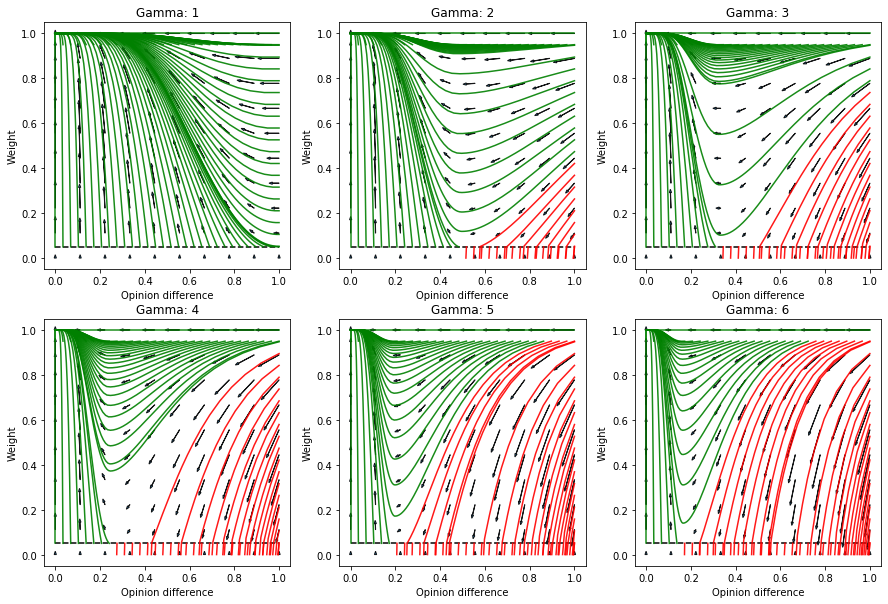

In [9]:
#Adjust the grid for gamma plots
grid = []
for weight in np.linspace(0, 1, 20):
    grid.append([1, weight])
for diff in np.linspace(0, 1, 30):
    grid.append([diff,0.95])
for diff in np.linspace(0, 1, 30):
    grid.append([diff, 0.05])
    
alpha = 0.03
beta = 0.3
gamma_array = [1,2,3,4,5,6]
ncolumns = 3
nrows = len(gamma_array)//ncolumns
fig, axes = plt.subplots(nrows, ncolumns, figsize=(ncolumns*5, nrows*5), sharex=True, sharey=True)
plt_index = 0

for gamma in gamma_array:
    plt_index += 1
    plt.subplot(nrows, ncolumns, plt_index)
    draw_vector_field(alpha, beta, gamma)
    plt.title('Gamma: %.0f' %gamma)
    plt.plot([0, 1], [0.05, 0.05], '--', color = "black")
    plt.xlabel('Opinion difference')
    plt.ylabel('Weight')
    
    for diff, weight in grid:
        sim = LocalAnalysis(gamma = gamma, difference = diff, weight = weight)
        result = monitor_variable(sim, diff, weight)
        plt.plot([result[time][0] for time in range(len(result))], 
            [result[time][1] for time in range(len(result))], 
            color = ("Red" if result[-1][1] == 0 else "Green"), alpha=0.9)

*Figure 3: The vector field plot at different values of gamma. Green lines represent converged cases, while red lines represent opinion split*

*Select appropriate values to use for the simulation in part 3*

From figure 1, figure 2, figure 3, we can find the critical value (or estimate the range for the critical value to stay in). At the critical value, the green area (likelihood of opinion converged) and the red area (likelihood of opinion split) are equal. Critcal values for $\alpha$, $\beta$, and $\gamma$ are:
$$0.02 \leq \alpha \leq 0.04 $$ 
$$0.28 \leq \beta \leq 0.46 $$
$$\gamma \approx 4 $$
In the next experiments, I will use two values for each parameters: one is greater and one is less than the critical value. 

*Use one or more vector field plots to demonstrate for which opinion and relationship strength values you expect clusters to form or to split apart in the simulation: *

From figure 1, we can predict whether the network will split or cluster. When $\alpha = 0.01$, the red area is greater than the green area, meaning that it's more likely that network will split apart. When $\alpha = 0.16$, the green area is greater than the red area, meaning that it's more likely that network will cluster.

# Part 3: Implementation

*Select and motivate for one of the types of random graphs mentioned in this course*

In my simulation, I don't use the Barabasi-Albert graph because the degree distribution of Barabasi-Albert graph can make it's harder for the network to split. In Barabasi-Albert graph, a few node will have very high node degree, so, other nodes' opinions are likely to converge to the opinion of a miniortiy group. I don't choose Erdos-Renyi graph because this network randomly distributes the edges among the nodes, which can't present human network. So, I choose Watts-Strogatz graph to both represent human's network and to easily recognize the split/cluster pattern. 

*Modify the Python Code for the modified model*

In [10]:
class ModifiedSocialDynamics():
    def __init__(self, size = 50, alpha = 0.03, beta = 0.3, gamma = 4, prob_new_edge = 0.01):
        """
        Size is the number of nodes in the network
        alpha is the rate at which a node adjust its opinion to get closer
            to its neighbor. 
            
        beta is the rate at which the weight of an edge changes in response
            to the opinion change. 
            
        gamma is the pickiness of a node. If the node difference is greater
            than 1/gamma, the edge weight will decrease. 
        """
        self.size = size
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.prob_new_edge = prob_new_edge
        
        #initialize the network configuration:
        self.config = nx.watts_strogatz_graph(size, 5, 0.5)

        #the initial weight of all edges is 0.5
        for edge in self.config.edges:
            self.config.edges[edge]['weight'] = 0.5
        #randomize the opinions in nodes between 0 and 1:
        for node in self.config.nodes:
            self.config.nodes[node]['opinion'] = random.randint(0, 1)
        #assign the charisma for each node in the network:
        for node in self.config.nodes:
            if random.random() < 0.5:
                self.config.nodes[node]['charisma'] = 2 #High impact on opinion difference and weight
            else:
                self.config.nodes[node]['charisma'] = 1 #No impact on opinion difference and weight
                
        self.layout = nx.spring_layout(self.config)
        self.step = 0
        self.converge = False
        self.split = False
        
    def display(self):
        """
        Draw the network
        """
        self.layout = nx.spring_layout(self.config, pos = self.layout, iterations = 5)
        
        nx.draw(
            self.config, pos = self.layout,
            node_color = [self.config.nodes[i]['opinion'] for i in self.config.nodes], with_labels = True,
            edge_color = [self.config.edges[edge]['weight'] for edge in self.config.edges],
            edge_cmap = plt.cm.binary, edge_vmin = 0, edge_vmax = 1,
            alpha = 0.7, vmin = 0, vmax = 1)
        plt.title("Step: " + str(self.step))
    
    def check_converge(self):
        """
        Check if the network is converged or not.
        The result will show in self.converge attribute.
        A network is converged if the largest opinion difference in the network is less than 0.1
        """
        opinions = [self.config.nodes[node]['opinion'] for node in self.config.nodes]
        if max(opinions) - min(opinions) < 0.1:
            self.converge = True
        else:
            self.converge = False
            
    def check_split(self):
        """
        Check if the network is splitted into two clusters or not.
        The result will show in self.split attribute. 
        A network is split if the number of extreme edges - the edges that connect two extreme ideas,
        is less than 1% of the total number of edges.
        """
        
        extreme_edges = [] #The edges that connect two extremes ideas (opinion difference >= 0.5)
        for edge in self.config.edges:
            if abs(self.config.nodes[edge[0]]['opinion'] - self.config.nodes[edge[1]]['opinion']) >= 0.5:
                extreme_edges.append(edge)
        if len(extreme_edges)/len(self.config.edges) < 0.01:
            self.split = True
        else:
            self.split = False
                
    def update(self):
        if random.uniform(0, 1) < self.prob_new_edge:
            #Create a new edge with weight 0.5 between two unconnected nodes:
            nodes = list(self.config.nodes)
            count = 0 #Use count to avoid infinite loop
            while count < 1000:
                new_edge = np.random.choice(nodes, 2)
                #condition 1: the edge must be new:
                cond1 = new_edge not in self.config.edges
                #condiion2: the new edge connects two not-signficant ideas
                cond2 = abs(self.config.nodes[new_edge[0]]['opinion'] - self.config.nodes[new_edge[1]]['opinion']) < 0.5
                if cond1 and cond2:
                    break
                count += 1
            #Only append valid result, instead of the last result of the iteration
            if count < 1000:
                self.config.add_edge(new_edge[0], new_edge[1], weight = 0.5)
            
        else:
            #select a random edge and update node opinions and edge weight:
            edge = random.choice(list(self.config.edges))
            weight = self.config.edges[edge]['weight']
            opinions = [self.config.nodes[node]['opinion'] for node in edge]
            charismas = [self.config.nodes[node]['charisma'] for node in edge]
            
            for i in [0, 1]:
                #update the opinion of each node in the random edge.
                #the opinion change for one node (i) is dependent on the charistma of the other node (1-i)
                self.config.nodes[edge[i]]['opinion'] = (
                    opinions[i] + charismas[1-i]*self.alpha*weight*(opinions[1-i] - opinions[i]))
                
            #update the weight between two nodes after the opinion change
            if 1-self.gamma*abs(opinions[0] - opinions[1]) > 0:
                #If the relationship is supposed to be stronger, the charisma accelerates that increase:
                #this impact is shown in the coefficient (max(charismas))
                self.config.edges[edge]['weight'] = (
                    weight + max(charismas)*self.beta*weight*(1-weight)*(1-self.gamma*abs(opinions[0] - opinions[1])))
            else: 
                #if the relationship is supposed to be weaker, the charisma slows down that decrease:
                #this impact is shown in the coefficient 1/(max(charismas))
                self.config.edges[edge]['weight'] = (
                    weight + 1/(max(charismas))*self.beta*weight*(1-weight)*(1-self.gamma*abs(opinions[0] - opinions[1])))
            #remove weak connections:
            if self.config.edges[edge]['weight'] < 0.05:
                self.config.remove_edge(*edge)
        self.step += 1

# Part 4: Simulation Analysis

*Run experiments to determine under what conditions social clusters form and under what conditions they split apart*

- Run the expriments for $\alpha$ = 0.1 and $\alpha$ = 0.01. We observe a network cluster at $\alpha$ = 0.1 (figure 4) and network split at $\alpha$ = 0.01 (figure 5). At lower $\alpha$ means that the opinion adjustment is low, compared to the weight decreases, meaning that opinion change is too low and people hate each other before they can reach a consensus. Higher $\alpha$ increases the opinion adjustment, thus, leads to rapid opinion convergence as people quickly change their opinion to reach a consensus.

In [11]:
sim1 = ModifiedSocialDynamics(alpha = 0.1)
sim2 = copy.deepcopy(sim1)
sim2.alpha = 0.01

Alpha:  0.1


/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):


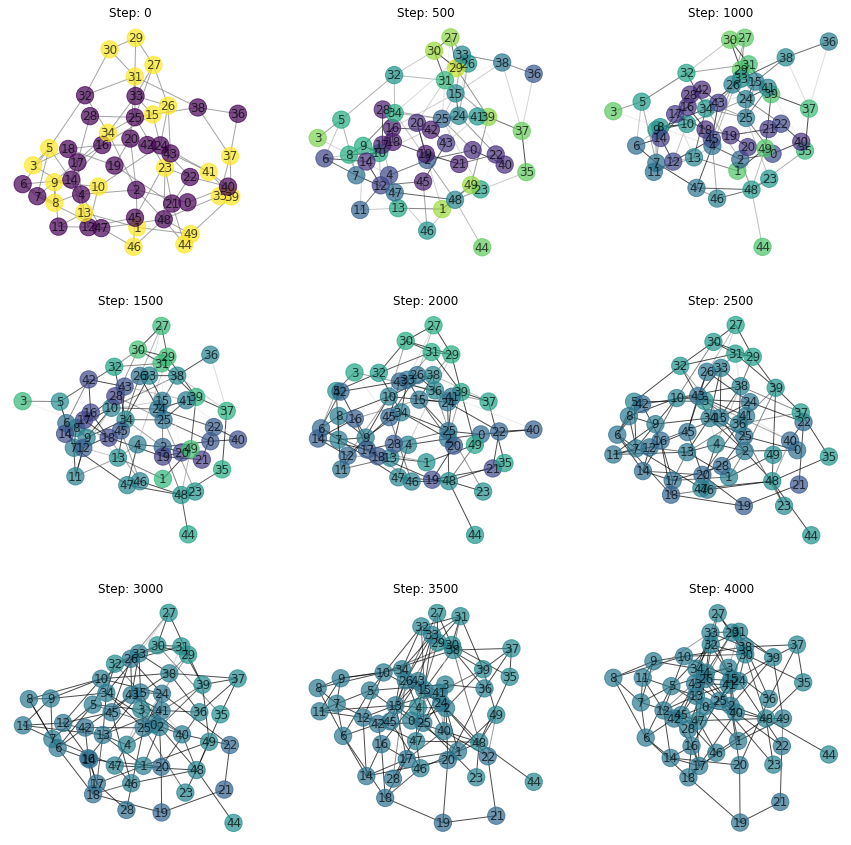

In [12]:
print("Alpha: ", 0.1)

ncolumns = 3
nrows = 3
fig, axes = plt.subplots(nrows, ncolumns, figsize=(ncolumns*5, nrows*5), sharex=True, sharey=True)
plt_index = 1

for i in range(9):
    plt.subplot(nrows, ncolumns, plt_index)
    sim1.display()
    plt_index += 1
    for i in range(500):
        sim1.update()

*Figure 4: Network clusters at $\alpha$ = 0.1*

Alpha:  0.01


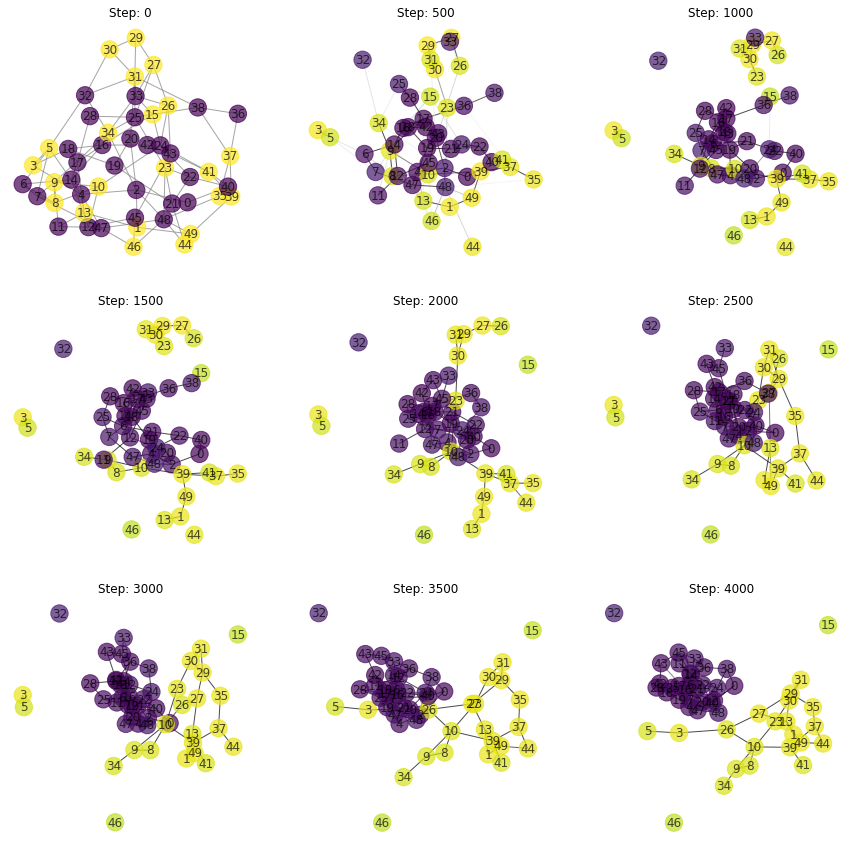

In [13]:
print("Alpha: ", 0.01)

ncolumns = 3
nrows = 3
fig, axes = plt.subplots(nrows, ncolumns, figsize=(ncolumns*5, nrows*5), sharex=True, sharey=True)
plt_index = 1

for i in range(9):
    plt.subplot(nrows, ncolumns, plt_index)
    sim2.display()
    for i in range(500):
        sim2.update()
    plt_index += 1

*Figure 5: Network splits at $\alpha$ = 0.01*

- Run the expriments for $\beta$ = 0.5 and $\beta$ = 0.05. The network splits aparts at $\beta$ = 0.5 (figure 6), and the network clusters at $\beta$ = 0.05 (figure 7). The difference is due to the mathematical impact of $\beta$ on edge's weight (analyzed in Part 2). A low $\beta$ means that the rate of weight change is low, so, it's easier to converge two opinions as their relationship still maintains. If $\beta$ is high, the relationship change will be faster. Rapid relationship change can accelerate the relationship split if the opinion difference is associated with relationship weaken (determined by $\gamma$ session below).   

In [14]:
sim1 = ModifiedSocialDynamics(beta = 0.5)
sim2 = copy.deepcopy(sim1)
sim2.beta = 0.05

Beta  0.5


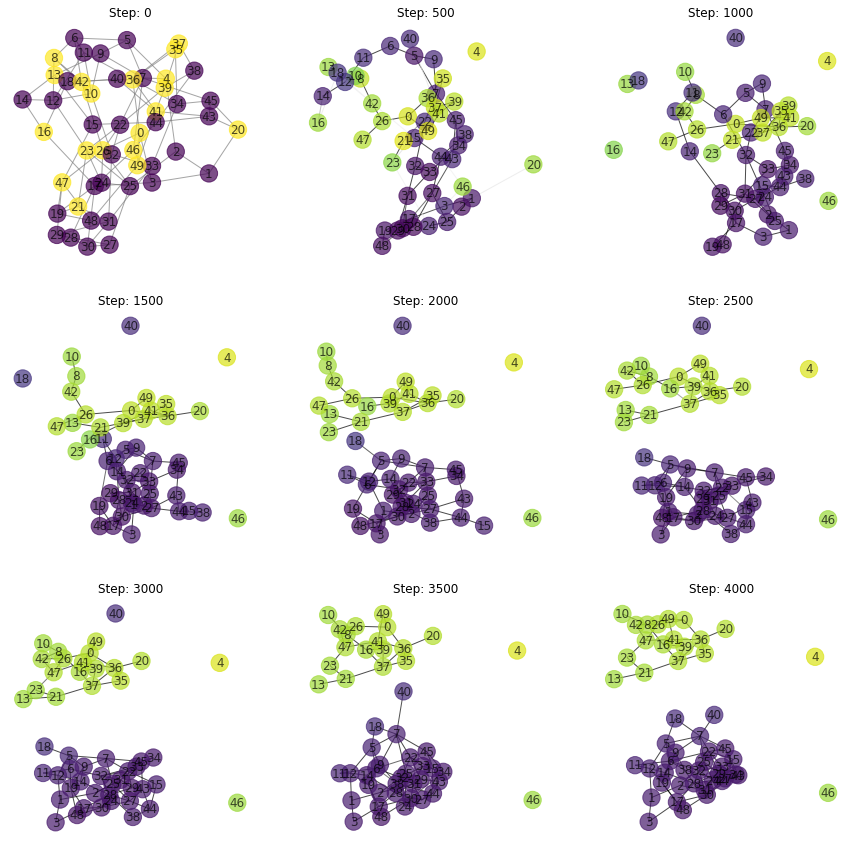

In [15]:
print("Beta ", 0.5)

ncolumns = 3
nrows = 3
fig, axes = plt.subplots(nrows, ncolumns, figsize=(ncolumns*5, nrows*5), sharex=True, sharey=True)
plt_index = 1

for i in range(9):
    plt.subplot(nrows, ncolumns, plt_index)
    sim1.display()
    plt_index += 1
    for i in range(500):
        sim1.update()

*Figure 6: Network splits at $\beta$ = 0.5*

Beta:  0.05


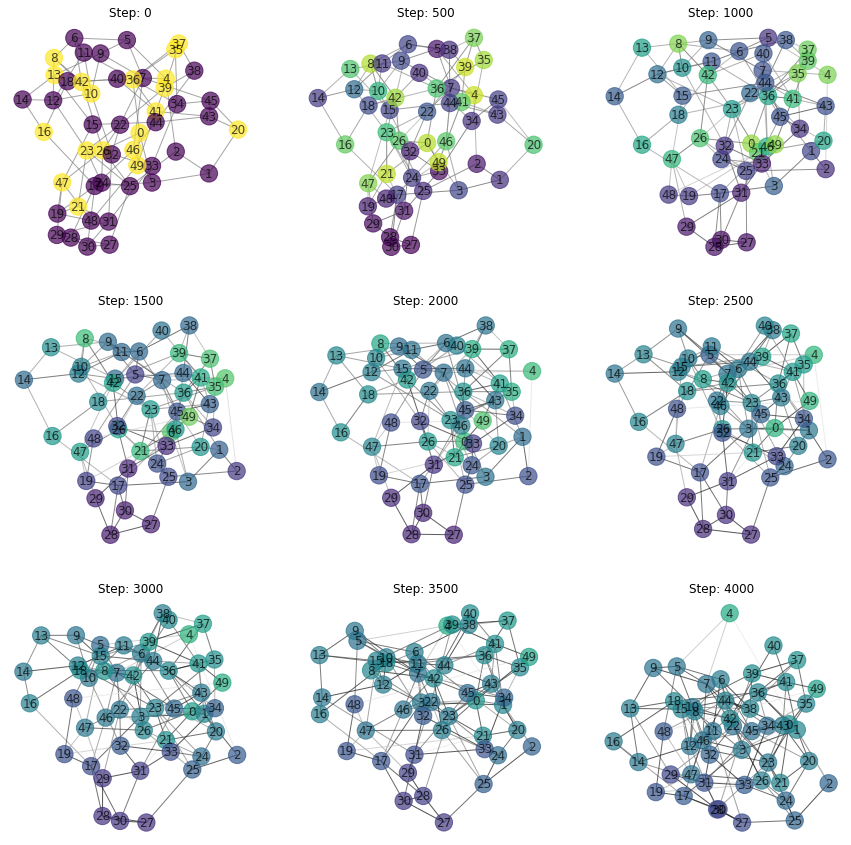

In [16]:
print("Beta: ", 0.05)

ncolumns = 3
nrows = 3
fig, axes = plt.subplots(nrows, ncolumns, figsize=(ncolumns*5, nrows*5), sharex=True, sharey=True)
plt_index = 1

for i in range(9):
    plt.subplot(nrows, ncolumns, plt_index)
    sim2.display()
    plt_index += 1
    for i in range(500):
        sim2.update()

*Figure 7: Network clusters at $\beta$ = 0.05*

- Run the expriments for $\gamma$ = 5 and $\gamma$ = 1. The network splits at $\gamma$ = 5 (figure 8) and network clusters at $\gamma$ = 1 (figure 9). A high $\gamma$ associates with weight decreases (thus, network splits) as it's more likely that $(1-\gamma |o_j - o_i|) < 0$. A low $\gamma$ associates with weight increases (thus, network clusters) as it's more likely that $w_{ij}' - w_{ij} > 0$.

In [17]:
sim1 = ModifiedSocialDynamics(gamma = 5)
sim2 = copy.deepcopy(sim1)
sim2.gamma = 1

Gamma:  5


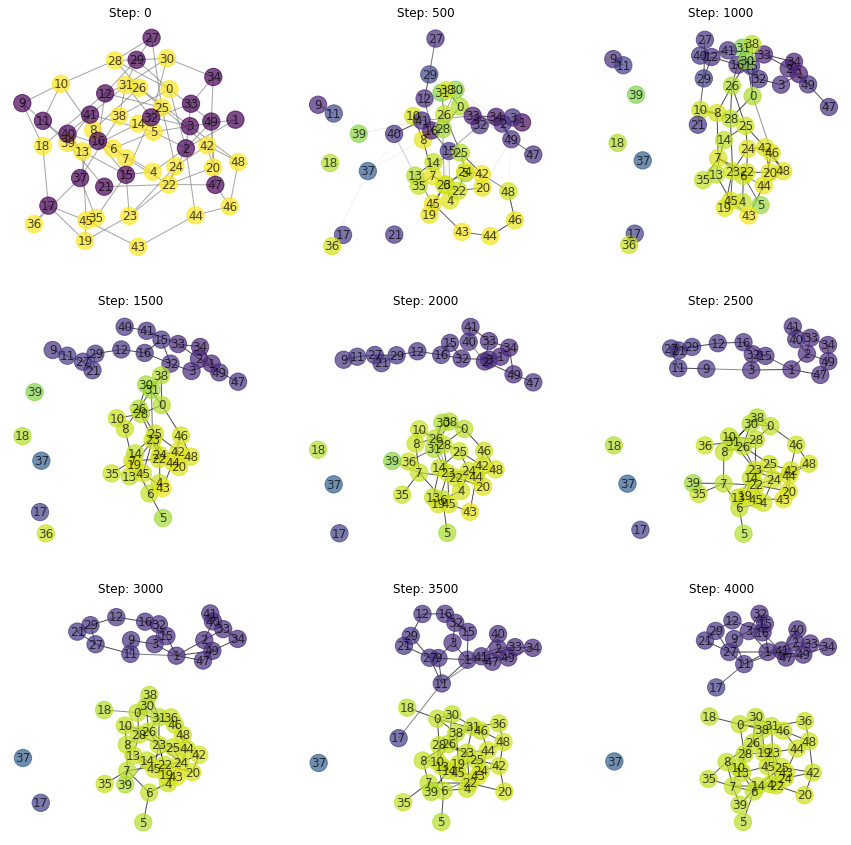

In [18]:
print("Gamma: ", 5)

ncolumns = 3
nrows = 3
fig, axes = plt.subplots(nrows, ncolumns, figsize=(ncolumns*5, nrows*5), sharex=True, sharey=True)
plt_index = 1

for i in range(9):
    plt.subplot(nrows, ncolumns, plt_index)
    sim1.display()
    plt_index += 1
    for i in range(500):
        sim1.update()

*Figure 8: Network splits at $\gamma$ = 5*

Gamma:  1


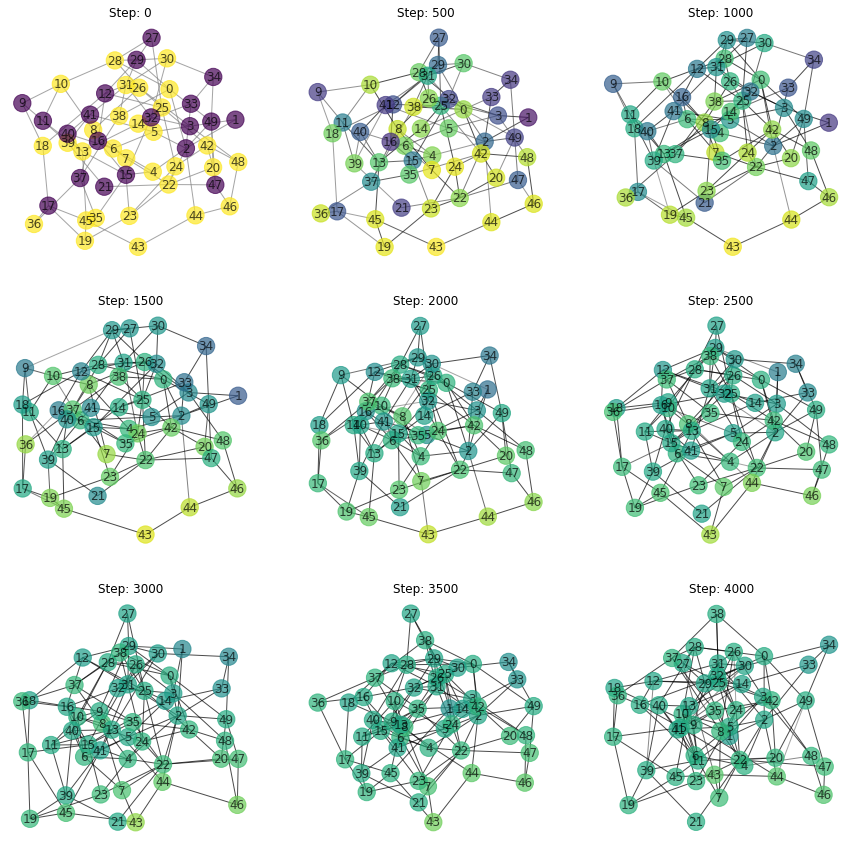

In [19]:
print("Gamma: ", 1)

ncolumns = 3
nrows = 3
fig, axes = plt.subplots(nrows, ncolumns, figsize=(ncolumns*5, nrows*5), sharex=True, sharey=True)
plt_index = 1

for i in range(9):
    plt.subplot(nrows, ncolumns, plt_index)
    sim2.display()
    plt_index += 1
    for i in range(500):
        sim2.update()

*Figure 9: Network clusters at $\gamma$ = 1*

In [20]:
def calculate_converge_time(sim):
    """
    Run the simulation until the network converge (check by method check_converge of the class).
    Also, the maxium sim steps allowed is 20000
    """
    jump = 10
    while sim.converge == False and sim.step < 20000:
        for _ in range(jump):
            sim.update()
        sim.check_converge()
        
    if sim.step < 20000:
        return sim.step

In [21]:
def calculate_split_time(sim):
    """
    Run the simulation until the network split (check by method check_split of the class).
    Also, the maxium sim steps allowed is 20000
    """
    jump = 10
    while sim.split == False and sim.step < 20000:
        for _ in range(jump):
            sim.update()
        sim.check_split()
        
    if sim.step < 20000:
        return sim.step

In [22]:
#Create a population pool of size 20 to run expriments:
size = 20
population = []

for _ in range(size):
    sim = ModifiedSocialDynamics()
    population.append(sim.config)

In [23]:
#Calculate time to converge for the basic model and the modified model:
mean_modify= []
std_modify = []
mean_basic = []
std_basic = []

for alpha in np.linspace(0.1, 0.5, 5):
    temp_array_1 = [] #For modified model
    temp_array_0 = [] #For basic model
    for config in population:
        sim1 = ModifiedSocialDynamics(alpha = alpha)
        sim1.config = copy.deepcopy(config)
        sim0 = BasicSocialDynamics(alpha = alpha)
        sim0.config = copy.deepcopy(config)
        result1 = calculate_converge_time(sim1)
        result0 = calculate_converge_time(sim0)
        
        if result1 != None:
            temp_array_1.append(result1)
        if result0 != None:
            temp_array_0.append(result0) 
        
    mean_modify.append(np.mean(temp_array_1))
    std_modify.append(np.std(temp_array_1))
    mean_basic.append(np.mean(temp_array_0))
    std_basic.append(np.std(temp_array_0))

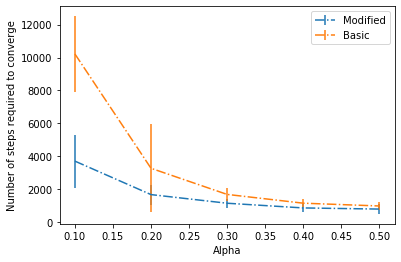

In [24]:
plt.figure()
plt.errorbar(np.linspace(0.1, 0.5, 5), mean_modify, yerr = 1.96*(np.array(std_modify)), linestyle = '-.',
    label = "Modified")
plt.errorbar(np.linspace(0.1, 0.5, 5), mean_basic, yerr = 1.96*(np.array(std_basic)), linestyle = '-.',
    label = "Basic")
plt.xlabel("Alpha")
plt.ylabel("Number of steps required to converge")
plt.legend()
plt.show()

*Figure 10: The time required for convergene of the basic model and the modified model*

In [25]:
#Calculate time to split for the basic model and the modified model:
mean_modify= []
std_modify = []
mean_basic = []
std_basic = []

for alpha in np.linspace(0.01, 0.04, 4):
    temp_array_1 = [] #For modified model
    temp_array_0 = [] #For basic model
    for config in population:
        sim1 = ModifiedSocialDynamics(alpha = alpha)
        sim1.config = copy.deepcopy(config)
        sim0 = BasicSocialDynamics(alpha = alpha)
        sim0.config = copy.deepcopy(config)
        result1 = calculate_split_time(sim1)
        result0 = calculate_split_time(sim0)
        
        if result1 != None:
            temp_array_1.append(result1)
        if result0 != None:
            temp_array_0.append(result0) 
        
    mean_modify.append(np.mean(temp_array_1))
    std_modify.append(np.std(temp_array_1))
    mean_basic.append(np.mean(temp_array_0))
    std_basic.append(np.std(temp_array_0))

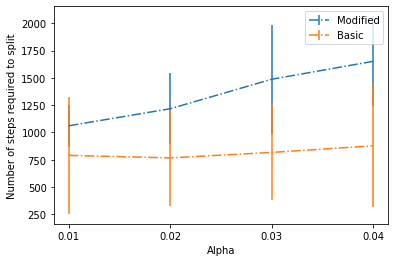

In [26]:
plt.figure()
plt.errorbar(np.linspace(0.01, 0.04, 4), mean_modify, yerr = 1.96*(np.array(std_modify)), linestyle = '-.',
    label = "Modified")
plt.errorbar(np.linspace(0.01, 0.04, 4), mean_basic, yerr = 1.96*(np.array(std_basic)), linestyle = '-.',
    label = "Basic")
plt.xlabel("Alpha")
plt.ylabel("Number of steps required to split")
plt.xticks(np.linspace(0.01, 0.04, 4))
plt.legend()
plt.show()

*Figure 11: The time required for network split of the basic model and the modified model*

The modified model takes shorter time to be clustered, compared to the basic model (figure 10). Due to the presence of the charismatic nodes, the opinion difference quickly narrows down, at the rate faster than the weight decreases.
The modified model takes larger time to split apart, compared to the basic model (figure 11). Although the second modification prohibits the new edge between two significant ideas (which result in early split apart), the impact of the charisma is possibly stronger. Charismatic nodes can slow down the weight decreases (shown in the weight function of the modified model).

This simulation aims to present the factors that affect the opinion dynamic in the population. The second modification (selective new edge) results from social media impact. For example, social media can predict the policial view of a specifc user, and provides news close to that political view. Those news connect people who have similar political views. Also, when the charisma effect reduces (results from the hatred speeches), the society will easily split (for example in the 2016 Presidential Election in the USA). 

# Appendix:

Additional HC:
- multiplecauses: In part 2, I explained mutliple effects of parameters (alpha, beta, gamma) and their interactions to explain the opinion difference and the weight change. 
- systemdynamics: I used the vector field plot to find the critical values for each parameter, using the simulation of a two-node system. 